In [2]:
from skimage import morphology,draw
import numpy as np
import matplotlib.pyplot as plt
import cv2

def readimage(t_name):
    image = cv2.imread(t_name,cv2.IMREAD_GRAYSCALE)
    ret,image=cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    image=255-image

    #实施骨架算法
    skeleton =morphology.skeletonize(image)

    skeleton=255-skeleton
    image=255-image
    skeleton[skeleton!=255]=0
    return image,skeleton

In [3]:
def is_interior(image,x,y):
    image=255-image
    left=np.sum(image[:x,y])
    right=np.sum(image[x:,y])
    down=np.sum(image[x,:y])
    up=np.sum(image[x,y:])
    image=255-image
    if left>0 and right>0 and down>0 and up>0:
        return True
    else:
        return False

def fill_feature(imageraw):
    image=np.copy(imageraw)
    image[image!=255]=0
    N=500
    feat=np.zeros(16)
    for x in range(N):
        for y in range(N):
            if image[x][y]==255 and is_interior(image,x,y):
                image[x][y]=0
    for i in range(4):
        for j in range(4):
            feat[4*i+j]=np.sum(255-image[125*i:125*(i+1),125*j:125*(j+1)])/255
    return image,feat


In [4]:
def features0(img):
    sumleft=np.zeros((4))
    for i in range(4):
        for x in range(125):
            for y in range(500):
                if img[x+i*125][y]==0:
                    sumleft[i]+=y

    sumright=np.zeros((4))
    for i in range(4):
        for x in range(125):
            for y in range(500):
                if img[x+i*125][499-y]==0:
                    sumright[i]+=y

    sumup=np.zeros((4))
    for i in range(4):
        for y in range(125):
            for x in range(500):
                if img[x][y+i*125]==0:
                    sumup[i]+=x

    sumdown=np.zeros((4))
    for i in range(4):
        for y in range(125):
            for x in range(500):
                if img[499-x][y+i*125]==0:
                    sumdown[i]+=x

    feature2=np.concatenate((sumleft,sumright,sumup,sumdown),axis=0)
    sumleft3=np.zeros((4))
    for i in range(4):
        for x in range(125):
            flag=0
            begin=0
            for y in range(500):
                if img[x+i*125][y]==0 and flag==0:
                    flag+=1
                if img[x+i*125][y]==255 and flag==1:
                    flag+=1
                    begin=y
                if img[x+i*125][y]==0 and flag==2:
                    flag+=1
                    sumleft3[i]+=y-begin

    sumright3=np.zeros((4))
    for i in range(4):
        for x in range(125):
            flag=0
            begin=0
            for y in range(500):
                if img[x+i*125][499-y]==0  and flag==0:
                    flag+=1
                if img[x+i*125][499-y]==255  and flag==1:
                    flag+=1
                    begin=y
                if img[x+i*125][499-y]==0  and flag==2:
                    flag+=1
                    sumright3[i]+=y-begin

    sumup3=np.zeros((4))
    for i in range(4):
        for y in range(125):
            flag=0
            begin=0
            for x in range(500):
                if img[x][y+i*125]==0 and flag==0:
                    flag+=1
                if img[x][y+i*125]==255 and flag==1:
                    flag+=1
                    begin=x
                if img[x][y+i*125]==0 and flag==2:
                    flag+=1
                    sumup3[i]+=x-begin

    sumdown3=np.zeros((4))
    for i in range(4):
        for y in range(125):
            flag=0
            begin=0
            for x in range(500):
                if img[499-x][y+i*125]==0 and flag==0:
                    flag+=1
                if img[499-x][y+i*125]==255 and flag==1:
                    flag+=1
                    begin=x
                if img[499-x][y+i*125]==0 and flag==2:
                    flag+=1
                    sumdown3[i]+=x-begin

    feature3=np.concatenate((sumleft3,sumright3,sumup3,sumdown3),axis=0)
    feature23=np.concatenate((feature2,feature3),axis=0)
    return feature23

In [5]:
def get_feature23(t_name):
    _,skeleton=readimage(t_name)
    return features0(skeleton)

In [6]:
def get_fill_feature(t_name):
    _,skeleton=readimage(t_name)
    return fill_feature(skeleton)[1]

In [7]:
import os

a = np.zeros((209, 32))
b = np.zeros((696, 32))
d = np.zeros((10, 32))
pathfu = "./traindata/fu/"
pathnotfu = "./traindata/not_fu/"
pathtest = "./testdata/"

import multiprocessing
num_processes = multiprocessing.cpu_count()-1 # 使用核心数
pool = multiprocessing.Pool(processes=num_processes) # 实例化进程池
result=pool.map(get_feature23,[pathfu + i for i in os.listdir(pathfu)])
# result1=pool.map(get_fill_feature,[pathfu + i for i in os.listdir(pathfu)])
for i in range(len(result)):
    a[i][0:32]=result[i]
    # a[i][32:]=result1[i]

In [8]:
result=pool.map(get_feature23,[pathnotfu + i for i in os.listdir(pathnotfu)])
for i in range(len(result)):
    b[i]=result[i]

In [9]:
result=pool.map(get_feature23,[pathtest + i for i in os.listdir(pathtest)])
for i in range(len(result)):
    d[i]=result[i]

In [89]:
X = np.concatenate((a, b), axis=0)
y = np.concatenate((np.ones(209), 0*np.ones(696)))

In [91]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [90]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.manifold import LocallyLinearEmbedding
embedding = make_pipeline(StandardScaler(),LocallyLinearEmbedding(n_components=3,method="modified",eigen_solver='dense'))
X_transformed = embedding.fit_transform(X)
X_transformed.shape

(905, 3)

In [93]:
new_d=embedding.fit_transform(d)

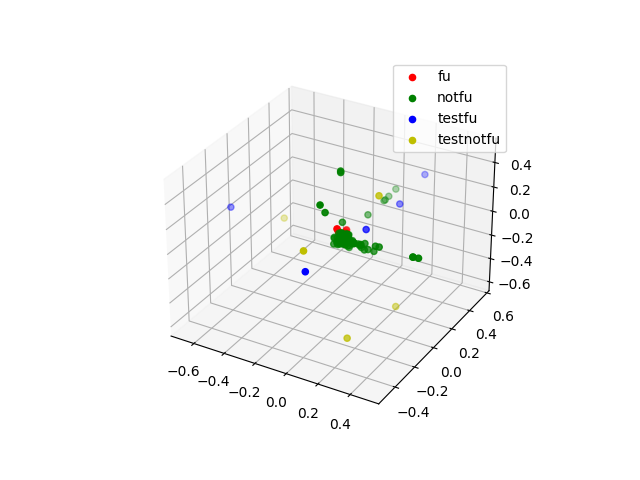

In [105]:
%matplotlib widget
# fig, ax = plt.subplots()
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(X_transformed[:209,0],X_transformed[:209,1],X_transformed[:209,2],c="r",label="fu")
ax.scatter(X_transformed[209:,0],X_transformed[209:,1],X_transformed[209:,2],c="g",label="notfu")
ax.scatter(new_d[:5,0],new_d[:5,1],new_d[:5,2],c="b",label="testfu")
ax.scatter(new_d[5:,0],new_d[5:,1],new_d[5:,2],c="y",label="testnotfu")
ax.legend()
ax.grid(True)

plt.show()

In [69]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


def intersection(hist_1, hist_2):
    minima = np.minimum(hist_1, hist_2)
    a = np.sum(minima)
    return a


def kernal(X1, X2):
    result = np.zeros((len(X1), len(X2)))
    for i in range(len(X1)):
        for j in range(len(X2)):
            result[i][j] = intersection(X1[i, :], X2[j, :])
    return result


clf = make_pipeline(SVC(gamma="auto", kernel="rbf"))
clf.fit(X_train, y_train)

Pipeline(steps=[('svc', SVC(gamma='auto'))])

In [56]:
from sklearn.ensemble import RandomForestClassifier

clf = make_pipeline(RandomForestClassifier())
clf.fit(X_train, y_train)

Pipeline(steps=[('randomforestclassifier', RandomForestClassifier())])

In [66]:
from sklearn.ensemble import GradientBoostingClassifier

clf = make_pipeline( GradientBoostingClassifier())
clf.fit(X_train, y_train)

Pipeline(steps=[('gradientboostingclassifier', GradientBoostingClassifier())])

In [58]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf = make_pipeline(
     AdaBoostClassifier(n_estimators=100, random_state=0)
)
clf.fit(X_train, y_train)

Pipeline(steps=[('adaboostclassifier',
                 AdaBoostClassifier(n_estimators=100, random_state=0))])

In [60]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf = make_pipeline(LinearSVC(random_state=0, tol=1e-5))
clf.fit(X_train, y_train)

Pipeline(steps=[('linearsvc', LinearSVC(random_state=0, tol=1e-05))])

In [63]:
from sklearn.neighbors import KNeighborsClassifier

clf = make_pipeline(KNeighborsClassifier())
clf.fit(X_train, y_train)#0.79

Pipeline(steps=[('kneighborsclassifier', KNeighborsClassifier())])

In [96]:
from sklearn.metrics import f1_score

y_pred = clf.predict(X_test)
print(f1_score(y_test, y_pred, average="macro"))
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

0.7621996996996997


array([[130,  13],
       [ 15,  23]])

In [99]:
real = clf.predict(new_d)
print(real)
print(f1_score(np.concatenate(( np.ones(5),0* np.ones(5))),real, average="macro"))
print(confusion_matrix(real, np.concatenate(( np.ones(5), 0*np.ones(5)))))

[0 0 0 0 0 0 0 0 0 0]
0.3333333333333333
[[5 5]
 [0 0]]


In [85]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


def intersection(hist_1, hist_2):
    minima = np.minimum(hist_1, hist_2)
    a = np.sum(minima)
    return a


def kernal(X1, X2):
    result = np.zeros((len(X1), len(X2)))
    for i in range(len(X1)):
        for j in range(len(X2)):
            result[i][j] = intersection(X1[i, :], X2[j, :])
    return result


from sklearn.svm import OneClassSVM
clf = make_pipeline(OneClassSVM(nu=0.7,verbose=True,kernel="sigmoid"))
clf .fit(X_transformed[:209,:])

from sklearn.metrics import f1_score

y_pred = clf.predict(new_d)

print(y_pred)

print(f1_score(np.concatenate((np.ones(5), -np.ones(5))), y_pred, average="macro"))
from sklearn.metrics import confusion_matrix

confusion_matrix(np.concatenate((np.ones(5), -np.ones(5))), y_pred)

[LibSVM]*
optimization finished, #iter = 70
obj = 320.827378, rho = 10.747895
nSV = 147, nBSV = 144
[-1  1 -1 -1 -1 -1 -1  1  1  1]
0.29292929292929293


array([[2, 3],
       [4, 1]])

In [92]:

from sklearn.metrics import f1_score
from hyperopt import hp
import xgboost as xgb

def train(args):
    learning_rate=args["learning_rate"]
    n_estimators=args["n_estimators"]
    eta=args["eta"]
    max_depth=args["max_depth"]
    subsample=args["subsample"]
    colsample_bytree=args["colsample_bytree"]
    min_child_weight=args["min_child_weight"]
    reg_alpha=args["reg_alpha"]
    reg_lambda=args["reg_lambda"]

    model = xgb.XGBClassifier(learning_rate=learning_rate,n_estimators=n_estimators,eta=eta,
                              max_depth=max_depth,subsample=subsample,colsample_bytree=colsample_bytree,
                              min_child_weight=min_child_weight,reg_alpha=reg_alpha,reg_lambda=reg_lambda)
    model.fit(X_train, y_train)
    return model

def objective(args):
    model=train(args)
    y_pred=model.predict(X_test)
    f1=f1_score(y_test,y_pred,average="macro")
    return -f1

space={"learning_rate":hp.choice("learning_rate", [0.1]),
    "n_estimators":hp.choice("n_estimators",[50, 100, 150, 200, 300]), # 多少棵树
    "eta": hp.choice("eta",[0.05, 0.1, 0, 2, 0.3]),  # 学习率
    "max_depth": hp.choice("max_depth",range(2, 15, 1)),  # 树的最大深度
    "subsample": hp.uniform("subsample", 0.7, 0.9),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.98),  # 选择多少列构建一个树
    "min_child_weight": hp.choice("min_child_weight",range(1, 9, 1)),  # 叶子节点最小样本数目
    "reg_alpha": hp.choice("reg_alpha",[0, 0.01, 0.02, 0.05, 0.7, 0.1, 1]),
    "reg_lambda": hp.choice("reg_lambda",[0, 0.1, 0.5, 1])}

from hyperopt import fmin, tpe, space_eval
best = fmin(objective, space, algo=tpe.suggest, max_evals=500)
print(best)
print(space_eval(space, best))

100%|██████████| 500/500 [01:15<00:00,  6.59trial/s, best loss: -0.7621996996996997]
{'colsample_bytree': 0.7073071967604057, 'eta': 0, 'learning_rate': 0, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 4, 'reg_alpha': 6, 'reg_lambda': 3, 'subsample': 0.7300682187567341}
{'colsample_bytree': 0.7073071967604057, 'eta': 0.05, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 300, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.7300682187567341}


In [95]:
clf=train(space_eval(space, best))

In [101]:
p=clf.predict(X_transformed)
print(f1_score(np.concatenate((np.ones(209), 0*np.ones(696))), p, average="macro"))

0.89513531243705
